# States
# Nodes
# Edges
# Graph (build & invoke)

In [9]:
%%capture --no-stderr
%pip install --quiet -U langgraph

# <img src="2024-11-07-17-45-33.png" width="50%"/>

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
from langgraph.graph import StateGraph, START, END

# State

State as a simple data structure that we update as we execute the graph.

In [3]:
from typing_extensions import TypedDict

class State(TypedDict):
    
    graph_state: str
    kg_asked_question: str
    lv_asked_for_a_review: int

In [4]:
from typing import Literal
import random

def node1(state):
    print("Passing by node 1")
    state["graph_state"] = "Lucas giving a presentation"
    state["kg_asked_question"] = "It was a beautiful question!"
    state["lv_asked_for_a_review"] = 1
    return state

In [5]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node("node1", node1)

builder.add_edge(START, "node1")

builder.add_edge("node1", END)

graph = builder.compile()

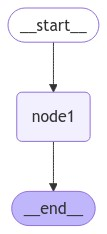

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"graph_state": ""})

Passing by node 1


{'graph_state': 'Lucas giving a presentation',
 'kg_asked_question': 'It was a beautiful question!',
 'lv_asked_for_a_review': 1}

In [8]:
from typing import Literal
import random

def node1(state):
    print("Passing by node 1")
    state["graph_state"] = "node 1"
    return state

def node2(state):
    print("Passing by node 2")
    state["graph_state"] = "node 2" 
    return state

def node3(state):
    print("Passing by node 3")
    state["graph_state"] = "node 3"
    return state

# Implementing some conditional logic
def decision_node(state) -> Literal["node2", "node3"]:
    
    user_input = state["graph_state"]
    
    if random.random() > 0.5:
        return "node2"
    else:
        return "node3"

In [9]:
builder = StateGraph(State)

builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

builder.add_edge(START, "node1")
builder.add_conditional_edges("node1",decision_node)
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph = builder.compile()

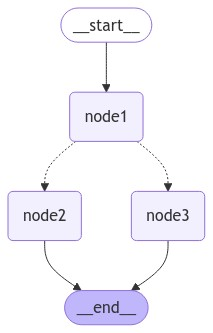

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
graph.invoke({"graph_state": ""})

Passing by node 1
Passing by node 2


{'graph_state': 'node 2'}